<a href="https://colab.research.google.com/github/pushyag1/DeepLearningClass/blob/master/Work3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/My Drive/MPDL Fall 2020/')

from mpdl import train_simple_network

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from mpdl import train_simple_network, Flatten, weight_reset

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [3]:
torch.backends.cudnn.deterministic=True
from mpdl import set_seed, moveTo
set_seed(42)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Question 1

Modify  `LanguageNameDataset` the so that the `vocabulary` object in the constructor does not need to be passed in as an argument, but instead can be _inferred_ from the input dataset. This means you will need to iterate through the dataset, and create a dictionary with all of the characters _actually seen_. One way to implement this is to create a default value  `vocabulary=None`, and use `is vocabulary None:` to change behavior. 


In [5]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

#Zip file is organized as data/names/[LANG].txt , where [LANG] is a specific language

In [6]:
namge_language_data = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too. 

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [7]:
class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary=None):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        d=[]
        s=[]
        l=[]
        def split(word):              #Split definition
          return[char for char in word]
        def convert(set):             #converting a set to list definition
          return list(set) 
  
        if vocabulary is None:        #if the vocabulary is none then the following loop will execute
          for i in lang_name_dict :    #the names are accessed and saved in 'd' list
            d.append(lang_name_dict[i]) 
 

          for word in d:               #the charachters split is done here and appened in 's'
              for c in word:
                s.append(split(c))
                
          for i in s:                  #the characters from the dataset is taken and loaded
            for n in i:
              l.append(n)
              myset = set(l)
              sets=convert(myset)
              n_letters = len(sets)
              alphabet = {}
              for i in range(n_letters):
                alphabet[sets[i]] = i
              
              self.vocabulary=alphabet
              
          else:
           self.vocabulary = self.vocabulary
        


        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        #Convert the correct class label into a tensor for PyTorch
        # label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label

##https://www.geeksforgeeks.org/python-accessing-key-value-in-dictionary/
#https://www.geeksforgeeks.org/python-convert-set-into-a-list/


In [8]:
dataset = LanguageNameDataset(namge_language_data,None)  #here we are passing None for vocabulary

In [9]:
dataset.vocabulary

{' ': 16,
 "'": 10,
 ',': 13,
 'a': 5,
 'b': 21,
 'c': 26,
 'd': 6,
 'e': 24,
 'f': 17,
 'g': 4,
 'h': 7,
 'i': 22,
 'j': 14,
 'k': 28,
 'l': 18,
 'm': 2,
 'n': 9,
 'o': 3,
 'p': 11,
 'q': 8,
 'r': 0,
 's': 23,
 't': 12,
 'u': 27,
 'v': 15,
 'w': 19,
 'x': 1,
 'y': 20,
 'z': 25}

In [10]:
len(dataset.vocabulary)

29

In [11]:
train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [12]:
len(dataset)

20074

In [13]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following 
    the output of a PyTorch RNN module. 
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1    
    
    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1] #this will be h_t
        if(type(last_step) == tuple):#unless it's a tuple, 
            last_step = last_step[0]#then h_t is the first item in the tuple
        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        #reshaping so that everything is separate 
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1] 
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

In [14]:
D = 64
vocab_size = len(dataset.vocabulary)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  #the tanh activation is built into the RNN object, so we don't need to do it here!
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

In [15]:
loss_func = nn.CrossEntropyLoss()
batch_one_train = train_simple_network(first_rnn, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=5)

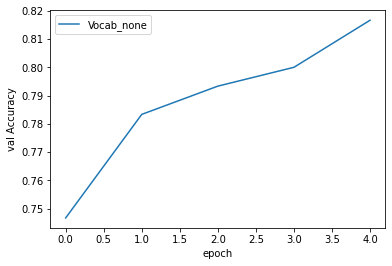

In [16]:
sns.lineplot(x='epoch', y='val Accuracy', data=batch_one_train, label='Vocab_none')

When the characters from the dataset is taken and loaded the same in place of pre defined alphabets, the accuracy for that is slightly more when compared to to loading the alphabets.

In [17]:
#https://careerkarma.com/blog/python-typeerror-list-indices-must-be-integers-or-slices-not-str/
#https://en.wikipedia.org/wiki/List_of_Unicode_characters
#https://www.geeksforgeeks.org/python-accessing-key-value-in-dictionary/
#https://www.codegrepper.com/code-examples/fortran/python+split+each+character+in+list
#https://www.techbeamers.com/python-add-lists-join-concatenate/
#https://stackoverflow.com/questions/12897374/get-unique-values-from-a-list-in-python
#https://stackoverflow.com/questions/27239313/making-a-function-as-an-else-inside-an-init/27239386

# Question 2

Update the `LanguageNameDataset` with a flag in the constructor for `unicode=False`. You should change any of the code you need to so that when `unicode=True`, the `LanguageNameDataset` will instead keep all the unicode characters seen when `vocabulary=None` (this depends on question 1). Train a new RNN classifier with `unicode=True`, how does it impact the results?


In [18]:
namge_language_data1 = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data1[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too. 

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [19]:
class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary=None,unicode=False):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        d=[]
        s=[]
        l=[]
        def split(word):               #same loop is taken from the question 1
          return[char for char in word]
        def convert(set): 
          return list(set) 
        
        if vocabulary is None:
          if unicode is False:          #when the vocabulary is none we are checking for the unicode values, if the unicode = false, then the unicode values arent taken
            for val in lang_name_dict:
              lang_name=[unicodeToAscii(x) for x in lang_name_dict[val]]
              lang_name_dict[val] = lang_name
          else:
            self.lang_name_dict=lang_name_dict   #when the unicode value is true then the unicode values are also considered.
            
          for i in lang_name_dict : 
            d.append(lang_name_dict[i]) 
 

          for word in d:
            for c in word:
              s.append(split(c))
                
          for i in s:
            for n in i:
              l.append(n)
              myset = set(l)
              sets=convert(myset)
              n_letters = len(sets)
              alphabet = {}
              for i in range(n_letters):
                alphabet[sets[i]] = i
                self.vocabulary=alphabet

              
        else:
          self.vocabulary = self.vocabulary
        


        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        #Convert the correct class label into a tensor for PyTorch
        # label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label

##https://www.geeksforgeeks.org/python-accessing-key-value-in-dictionary/
#https://www.geeksforgeeks.org/python-convert-set-into-a-list/


In [20]:
dataset = LanguageNameDataset(namge_language_data1,None, unicode=True) #passing unicode is true

In [21]:
dataset.vocabulary

{' ': 40,
 "'": 23,
 ',': 35,
 '-': 5,
 '/': 39,
 '1': 33,
 ':': 37,
 'a': 11,
 'b': 45,
 'c': 55,
 'd': 14,
 'e': 51,
 'f': 41,
 'g': 10,
 'h': 19,
 'i': 46,
 'j': 36,
 'k': 57,
 'l': 42,
 'm': 8,
 'n': 21,
 'o': 9,
 'p': 28,
 'q': 20,
 'r': 1,
 's': 50,
 't': 31,
 'u': 56,
 'v': 38,
 'w': 43,
 'x': 4,
 'y': 44,
 'z': 52,
 '\xa0': 30,
 'ß': 15,
 'à': 3,
 'á': 49,
 'ã': 47,
 'ä': 34,
 'ç': 18,
 'è': 24,
 'é': 29,
 'ê': 17,
 'ì': 25,
 'í': 26,
 'ñ': 13,
 'ò': 53,
 'ó': 27,
 'õ': 54,
 'ö': 6,
 'ù': 32,
 'ú': 16,
 'ü': 12,
 'ą': 22,
 'ł': 7,
 'ń': 48,
 'ś': 0,
 'ż': 2}

In [22]:
dataset.data

['khoury',
 'nahas',
 'daher',
 'gerges',
 'nazari',
 'maalouf',
 'gerges',
 'naifeh',
 'guirguis',
 'baba',
 'sabbagh',
 'attia',
 'tahan',
 'haddad',
 'aswad',
 'najjar',
 'dagher',
 'maloof',
 'isa',
 'asghar',
 'nader',
 'gaber',
 'abboud',
 'maalouf',
 'zogby',
 'srour',
 'bahar',
 'mustafa',
 'hanania',
 'daher',
 'tuma',
 'nahas',
 'saliba',
 'shamoon',
 'handal',
 'baba',
 'amari',
 'bahar',
 'atiyeh',
 'said',
 'khouri',
 'tahan',
 'baba',
 'mustafa',
 'guirguis',
 'sleiman',
 'seif',
 'dagher',
 'bahar',
 'gaber',
 'harb',
 'seif',
 'asker',
 'nader',
 'antar',
 'awad',
 'srour',
 'shadid',
 'hajjar',
 'hanania',
 'kalb',
 'shadid',
 'bazzi',
 'mustafa',
 'masih',
 'ghanem',
 'haddad',
 'isa',
 'antoun',
 'sarraf',
 'sleiman',
 'dagher',
 'najjar',
 'malouf',
 'nahas',
 'naser',
 'saliba',
 'shamon',
 'malouf',
 'kalb',
 'daher',
 'maalouf',
 'wasem',
 'kanaan',
 'naifeh',
 'boutros',
 'moghadam',
 'masih',
 'sleiman',
 'aswad',
 'cham',
 'assaf',
 'quraishi',
 'shalhoub',
 '

In [23]:
len(dataset.vocabulary)

58

In [24]:
train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [25]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following 
    the output of a PyTorch RNN module. 
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1    
    
    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1] #this will be h_t
        if(type(last_step) == tuple):#unless it's a tuple, 
            last_step = last_step[0]#then h_t is the first item in the tuple
        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        #reshaping so that everything is separate 
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1] 
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

In [26]:
D = 64
vocab_size = len(dataset.vocabulary)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  #the tanh activation is built into the RNN object, so we don't need to do it here!
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

In [27]:
loss_func = nn.CrossEntropyLoss()
batch_one_train = train_simple_network(first_rnn, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=5)

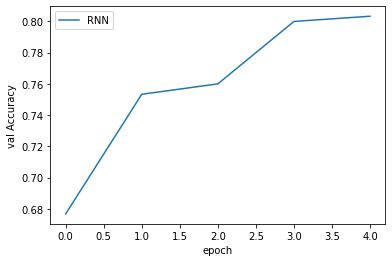

In [28]:
sns.lineplot(x='epoch', y='val Accuracy', data=batch_one_train, label='RNN')

When the unicode values are taken then there is a minute accuracy improvement in the results.

In [29]:
#https://en.wikipedia.org/wiki/Unicode_equivalence#Normal_forms

# Question 3

The original training/test split for this task was created by randomly sampling the dataset. Create your own function that performs _stratified_ splitting. This means it will select a test set that has the exact same proportions of each class. How does this impact your apparent results?


In [30]:
namge_language_data2 = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data2[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too. 

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [31]:
class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        #Conver the correct class label into a tensor for PyTorch
        # label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label

In [32]:
#from sklearn.model_selection import StratifiedShuffleSplit 

from sklearn.model_selection import train_test_split

In [33]:
dataset = LanguageNameDataset(namge_language_data2, alphabet)

In [34]:
X = dataset.data
X

['khoury',
 'nahas',
 'daher',
 'gerges',
 'nazari',
 'maalouf',
 'gerges',
 'naifeh',
 'guirguis',
 'baba',
 'sabbagh',
 'attia',
 'tahan',
 'haddad',
 'aswad',
 'najjar',
 'dagher',
 'maloof',
 'isa',
 'asghar',
 'nader',
 'gaber',
 'abboud',
 'maalouf',
 'zogby',
 'srour',
 'bahar',
 'mustafa',
 'hanania',
 'daher',
 'tuma',
 'nahas',
 'saliba',
 'shamoon',
 'handal',
 'baba',
 'amari',
 'bahar',
 'atiyeh',
 'said',
 'khouri',
 'tahan',
 'baba',
 'mustafa',
 'guirguis',
 'sleiman',
 'seif',
 'dagher',
 'bahar',
 'gaber',
 'harb',
 'seif',
 'asker',
 'nader',
 'antar',
 'awad',
 'srour',
 'shadid',
 'hajjar',
 'hanania',
 'kalb',
 'shadid',
 'bazzi',
 'mustafa',
 'masih',
 'ghanem',
 'haddad',
 'isa',
 'antoun',
 'sarraf',
 'sleiman',
 'dagher',
 'najjar',
 'malouf',
 'nahas',
 'naser',
 'saliba',
 'shamon',
 'malouf',
 'kalb',
 'daher',
 'maalouf',
 'wasem',
 'kanaan',
 'naifeh',
 'boutros',
 'moghadam',
 'masih',
 'sleiman',
 'aswad',
 'cham',
 'assaf',
 'quraishi',
 'shalhoub',
 '

In [35]:
targets = dataset.labels

In [36]:

train_idx, valid_idx= train_test_split(np.arange(len(targets)),test_size=0.2,shuffle=True,stratify=targets)

In [37]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=valid_sampler)

In [38]:
train_idx

array([  927, 18895, 15370, ...,  8662, 19293, 17805])

In [39]:
valid_idx

array([16276, 18479, 11263, ..., 17829,  8110, 10755])

In [40]:
len(train_idx)

16059

In [41]:
len(valid_idx)

4015

In [42]:
#https://discuss.pytorch.org/t/how-to-do-a-stratified-split/62290

In [43]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following 
    the output of a PyTorch RNN module. 
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1    
    
    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1] #this will be h_t
        if(type(last_step) == tuple):#unless it's a tuple, 
            last_step = last_step[0]#then h_t is the first item in the tuple
        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        #reshaping so that everything is separate 
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1] 
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

In [44]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  #the tanh activation is built into the RNN object, so we don't need to do it here!
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

In [45]:
loss_func = nn.CrossEntropyLoss()
batch_one_train = train_simple_network(first_rnn, loss_func, train_loader, val_loader=valid_loader, score_funcs={'Accuracy': accuracy_score},device=device, epochs=5)

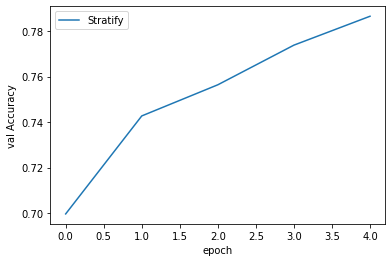

In [46]:
sns.lineplot(x='epoch', y='val Accuracy', data=batch_one_train, label='Stratify')

https://discuss.pytorch.org/t/how-to-do-a-stratified-split/62290

When the stratify split is taken instead of random split, the performace is good with a very minute improvement in the accuracy.

# Question 4

Replace the last output layer `nn.Linear(hidden_nodes, classes)` from the RNN implementation with a fully-connected network with 2 hidden layers and one output layer. How does this impact the accuracy of the model?


In [47]:
namge_language_data4 = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data4[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too. 

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [48]:
class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        #Conver the correct class label into a tensor for PyTorch
        # label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label

In [49]:
dataset = LanguageNameDataset(namge_language_data4, alphabet)

train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [50]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  #the tanh activation is built into the RNN object, so we don't need to do it here!
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, 50), #(B, D) -> (B, classes)
  nn.Linear(50, 50),
  nn.Linear(50, classes),
)

In [51]:
loss_func = nn.CrossEntropyLoss()
batch_one_train = train_simple_network(first_rnn, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=5)

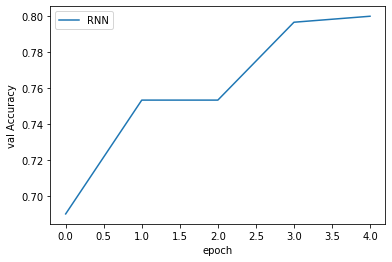

In [52]:
sns.lineplot(x='epoch', y='val Accuracy', data=batch_one_train, label='RNN')

In [53]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  #the tanh activation is built into the RNN object, so we don't need to do it here!
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, 15), #(B, D) -> (B, classes)
  nn.Linear(15, 15),
  nn.Linear(15, classes),
)

In [54]:
loss_func = nn.CrossEntropyLoss()
batch_one_train = train_simple_network(first_rnn, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=5)

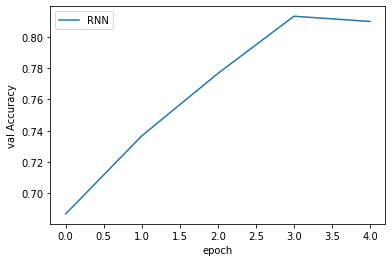

In [55]:
sns.lineplot(x='epoch', y='val Accuracy', data=batch_one_train, label='RNN')

Have added 50 neurons for the first model initially and the accuracy was pretty good and later decreased the neurons count and added 15 neurons for the 2 hidden layers and the accuracy was almost maximum for both the scenarios.

# Question 5

Compare training a 3-layer bidirectional RNN with batch sizes of $B=\{1, 2, 4, 8\}$ for 5 epochs. Which batch size seems to give the best balance between speed and accuracy?

In [56]:
dataset = LanguageNameDataset(namge_language_data4, alphabet)

In [57]:
def pad_and_pack(batch):
    #1, 2, & 3: organize the batch input lengths, inputs, and outputs as seperate lists
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0]) #Assume shape is (T, *)
    #4: create the padded version of the input
    x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    #5: create the packed version from the padded & lengths
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    #Convert the lengths into a tensor
    y_batched = torch.as_tensor(labels, dtype=torch.long)
    #6: return a tuple of the packed inputs and their labels
    return x_packed, y_batched


In [58]:
class EmbeddingPackable(nn.Module):
    """
    The embedding layer in PyTorch does not support Packed Sequence objects. 
    This wrapper class will fix that. If a normal input comes in, it will 
    use the regular Embedding layer. Otherwise, it will work on the packed 
    sequence to return a new Packed sequence of the appropriate result. 
    """
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer 
    
    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input, 
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.to(input.data.device), 
                                                           batch_first=True, enforce_sorted=False)
        else:#apply to normal data
            return self.embd_layer(input)


In [59]:
B = 8
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, collate_fn=pad_and_pack)

In [60]:
rnn_3layer_bidir_8 = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

rnn_3layer_bidir_8.to(device)

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(57, 64)
  )
  (1): RNN(64, 256, num_layers=3, batch_first=True, bidirectional=True)
  (2): LastTimeStep()
  (3): Linear(in_features=512, out_features=18, bias=True)
)

In [61]:
rnn_3layer_bidir_results_8 = train_simple_network(rnn_3layer_bidir_8, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, epochs=5, lr=0.01)

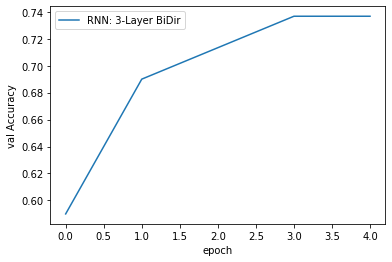

In [62]:
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_bidir_results_8, label='RNN: 3-Layer BiDir')


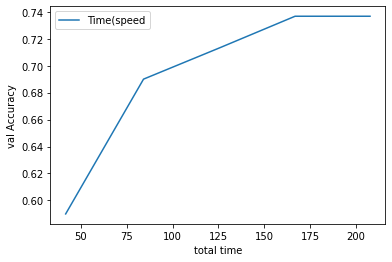

In [63]:
sns.lineplot(x='total time', y='val Accuracy', data=rnn_3layer_bidir_results_8, label='Time(speed')

In [64]:
B = 4
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, collate_fn=pad_and_pack)

In [65]:
rnn_3layer_bidir_4 = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

rnn_3layer_bidir_4.to(device)

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(57, 64)
  )
  (1): RNN(64, 256, num_layers=3, batch_first=True, bidirectional=True)
  (2): LastTimeStep()
  (3): Linear(in_features=512, out_features=18, bias=True)
)

In [66]:
rnn_3layer_bidir_results_4 = train_simple_network(rnn_3layer_bidir_4, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=5, lr=0.01)

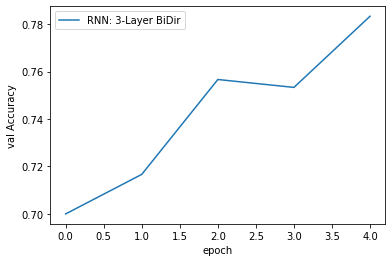

In [67]:
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_bidir_results_4, label='RNN: 3-Layer BiDir')


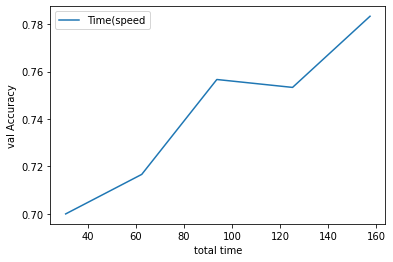

In [68]:
sns.lineplot(x='total time', y='val Accuracy', data=rnn_3layer_bidir_results_4, label='Time(speed')

In [69]:
B = 2
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, collate_fn=pad_and_pack)

In [70]:
rnn_3layer_bidir_2 = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

rnn_3layer_bidir_2.to(device)

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(57, 64)
  )
  (1): RNN(64, 256, num_layers=3, batch_first=True, bidirectional=True)
  (2): LastTimeStep()
  (3): Linear(in_features=512, out_features=18, bias=True)
)

In [71]:
rnn_3layer_bidir_results_2 = train_simple_network(rnn_3layer_bidir_2, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=5, lr=0.01)

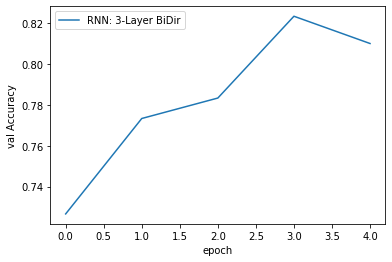

In [72]:
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_bidir_results_2, label='RNN: 3-Layer BiDir')


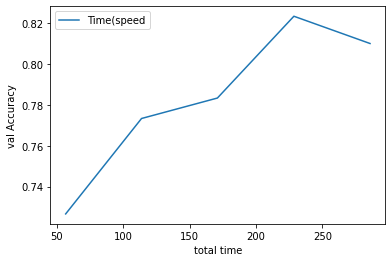

In [73]:
sns.lineplot(x='total time', y='val Accuracy', data=rnn_3layer_bidir_results_2, label='Time(speed')

In [74]:
B = 1
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, collate_fn=pad_and_pack)

In [75]:
rnn_3layer_bidir_1 = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

rnn_3layer_bidir_1.to(device)

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(57, 64)
  )
  (1): RNN(64, 256, num_layers=3, batch_first=True, bidirectional=True)
  (2): LastTimeStep()
  (3): Linear(in_features=512, out_features=18, bias=True)
)

In [76]:
rnn_3layer_bidir_results_1 = train_simple_network(rnn_3layer_bidir_1, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=5, lr=0.01)

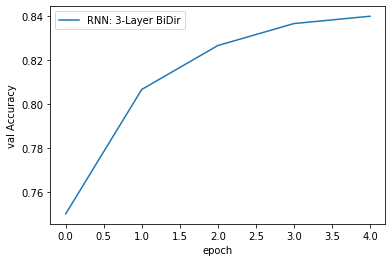

In [77]:
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_bidir_results_1, label='RNN: 3-Layer BiDir')


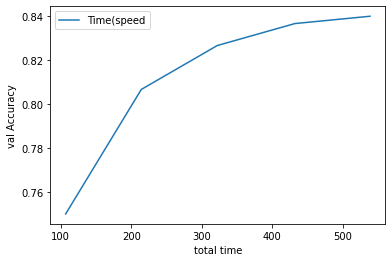

In [78]:
sns.lineplot(x='total time', y='val Accuracy', data=rnn_3layer_bidir_results_1, label='Time(speed')

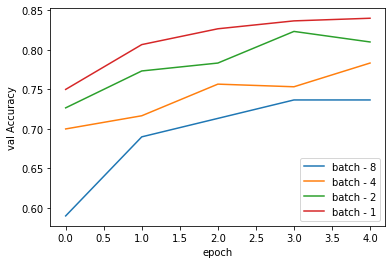

In [79]:
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_bidir_results_8, label='batch - 8')
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_bidir_results_4, label='batch - 4')
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_bidir_results_2, label='batch - 2')
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_bidir_results_1, label='batch - 1')

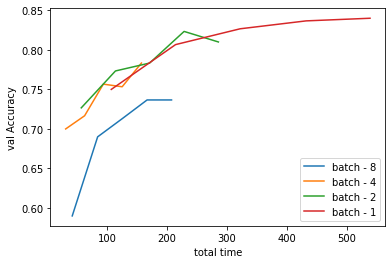

In [80]:
sns.lineplot(x='total time', y='val Accuracy', data=rnn_3layer_bidir_results_8, label='batch - 8')
sns.lineplot(x='total time', y='val Accuracy', data=rnn_3layer_bidir_results_4, label='batch - 4')
sns.lineplot(x='total time', y='val Accuracy', data=rnn_3layer_bidir_results_2, label='batch - 2')
sns.lineplot(x='total time', y='val Accuracy', data=rnn_3layer_bidir_results_1, label='batch - 1')

The accuracy for the batch 1 was more when compared with the accuracy of the batch size of 8, but the time taken by batch 8 comparitively less than batch 1, so as the batch size increases the time increases and the accuracy decreases.